# Organ segmentation reproduction sandbox

## Contents

1. Imports
2. Testing out TensorBoard
3. Create the dataset
4. Define the model architecture
5. Train the model
6. View the results
7. Test the model
8. Reproduce the results


In [16]:
# Setup
import os
import numpy as np # For general mathematical operations
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt # For plotting the results
from torchsummary import summary # For model summaries
from torch.utils.tensorboard import SummaryWriter # For writing into tensorboard
import nrrd # For reading and manipulating nrrd files
from glob import glob

%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



# Testing out tensorboard <a id="TensorBoardTest"></a>

In [17]:
writer = SummaryWriter(comment="Tensorboard Test")
x = torch.arange(-5, 5, 0.1).view(-1, 1)
y = -5 * x + 0.1 * torch.randn(x.size())

model = torch.nn.Linear(1, 1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

def train_model(iter):
    for epoch in range(iter):
        y1 = model(x)
        loss = criterion(y1, y)
        writer.add_scalar("Loss/train", loss, epoch)
        writer.add_scalar("New param 2", 5, epoch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

train_model(10)
writer.flush()

Remove test run after recognising it works (CAREFUL)

In [18]:
%rm -r runs

# Create the dataset

In [19]:
structures = [
    "BrainStem",
    "Chiasm",
    "Mandible",
    "OpticNerve_L",
    "OpticNerve_R",
    "Parotid_L",
    "Parotid_R",
    "Submandibular_L",
    "Submandibular_R"
]

## A sample image

The images are 3D images of human heads. The segmentations are 3D images, where the wanted part is "highlighted". The range of the image values is [0,1].

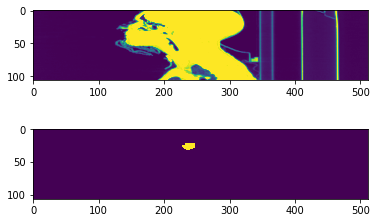

In [20]:

sample_fullimage, header_fullimage = nrrd.read("./data/raw/PDDCA-1.4.1_part1/0522c0001/img.nrrd")
sample_brainstem, header_brainstem = nrrd.read("./data/raw/PDDCA-1.4.1_part1/0522c0001/structures/BrainStem.nrrd")
fig, axs = plt.subplots(2,1)
axs[0].imshow(sample_fullimage[250,:,:][:,::-1].T, vmax=0.001)
axs[1].imshow(sample_brainstem[250,:,:][:,::-1].T, vmax=0.001)

In [44]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from pathlib import Path

def pad_tensor(t, output_size=512):
    l, w, h = t.shape
    missing = output_size - l
    zeros = torch.zeros(size=(missing, w, h))
    t = torch.concat([t, zeros])
    return t

class CustomImageDataset(Dataset):
    def __init__(self, image_paths, target_structure, transform=None, target_transform=None):
        self.image_paths = image_paths
        self.target_structure = target_structure
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = Path(self.image_paths[idx])
        image_filepath = image_path / "img.nrrd"
        structure_filepath = image_path / "structures" / (self.target_structure + ".nrrd")

        image, _ = nrrd.read(image_filepath)
        structure, _ = nrrd.read(structure_filepath)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            structure = self.target_transform(structure)
        return image, structure

In [45]:
# Read the filenames

raw_1_img_filepaths = glob("./data/raw/PDDCA-1.4.1_part1/*")

network_input_size = (256,256,48)

#torchvision.transforms.Resize(network_input_size)

train_transform = transforms.Compose([
            transforms.ToTensor(),
            pad_tensor,
        ])

# Create the dataset
train_set_brainstem = CustomImageDataset(
    raw_1_img_filepaths, 
    target_structure="BrainStem",
    transform=train_transform, 
    target_transform=train_transform, 
    )

# Define data loaders used to iterate through dataset
train_dataloader = DataLoader(train_set_brainstem, batch_size=8, shuffle=True)
#test_loader = DataLoader(test_data, batch_size=1000)


In [56]:
train_features, train_labels = next(iter(train_dataloader))

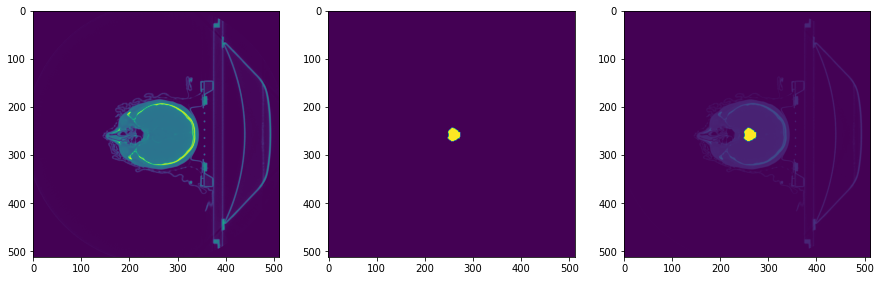

In [84]:
from copy import deepcopy

fig, axes = plt.subplots(1,3, figsize=(15, 15))
batch_idx = 6
idx = 100

stem = train_labels[batch_idx,idx,:,:]
stem_mask = train_labels[batch_idx,idx,:,:] > 0.00005
image = train_features[batch_idx,idx,:,:]

image_masked = deepcopy(image)
image_masked[stem_mask] = 10000

axes[0].imshow(image)
axes[1].imshow(stem)
axes[2].imshow(image_masked)


In [72]:
display(pd.DataFrame(train_labels[0,150,:,:]).describe())


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
count,512.0,512.0,512.0,512.0,512.0,512.0,512.0,512.0,512.0,512.0,...,512.0,512.0,512.0,512.0,512.0,512.0,512.0,512.0,512.0,512.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
train_features[0].shape
#pd.DataFrame(train_features[0,0]).describe().mean(axis=1)

torch.Size([512, 512, 512])

# Define the model

The model architecture as per the paper.

In [5]:
def conv_2x2d():
    pass

def conv_2x3d_coarse():
    pass

def conv_3d_fine():
    pass

class OrganNetRepro(torch.nn.Module):

    def __init__(self):
        """
        Initialize the network.
        """

        # 2D layers
        self.two_d_1 = conv_2x2d()
        self.two_d_2 = conv_2x2d()

        # Coarse 3D layers

        self.coarse_3d_1 = conv_2x3d_coarse()
        self.coarse_3d_2 = conv_2x3d_coarse()
        self.coarse_3d_3 = conv_2x3d_coarse()
        self.coarse_3d_4 = conv_2x3d_coarse()

        # Fine 3D block

        self.fine_3d_1 = conv_3d_fine()
        self.fine_3d_2 = conv_3d_fine()
        self.fine_3d_3 = conv_3d_fine()


        self.layers = [
            self.two_d_1,
            self.two_d_2,
            self.coarse_3d_1,
            self.coarse_3d_2,
            self.coarse_3d_3,
            self.coarse_3d_4,
            self.fine_3d_1,
            self.fine_3d_2,
            self.fine_3d_3,
        ]

    def forward():


        ## Part 1 (Left side)

        # Input to 2D layer 1 -> Output 1
        # Output 1 to pooling layer S(1,2,2) -> Output 2 # TODO what pooling is this?
        # Output 2 to coarse 3D layer 1 -> Output 3
        # Output 3 to pooling layer S(2,2,2) -> Output 4 # TODO what pooling?
        # Output 4 to Coarse 3D layer 2 -> Output 5
        # Output 5 to Fine 3D Layer 1 -> Output 6
        
        # Part 2 (Bottom, starting from the first Orange arrow)
        # Output 6 to Fine 3D Layer 2 -> Output 7
        # Output 7 to "Conv 1x1x1" layer 1 -> Output 8 # TODO Elaborate on the 1x1x1 layer
        # Concatenate Output 6 and Output 8 -> Output 9
        # Output 9 to Fine 3D Layer 3 -> Output 10
        
        # Part 3 (Right side, starting from the bottom right yellow arrow)
        # Output 10 to 1x1x1 layer 2 -> Output 11 # TODO still missing
        # Concatenate Output 11 and Output 5 -> Output 12
        # Output 12 to Coarse 3d layer 3 -> Output 13
        # Transpose Output 13 -> Output 14
        # Concatenate Output 14 and Output 3 -> Output 15
        # Output 15 to Coarse 3d Layer 4 -> Output 16
        # Concatenate Output 1 and Output 16 -> Output 17
        # Output 17 to 2D layer 2 -> Output 18
        # Output 18 to 1x1x1 layer 3 -> Final output
        
        pass
        


In [3]:
from src.Model.OrganNet25D import ToyOrganNet25D, OrganNet25D

batch = 2
width = height = 256
depth = 48
channels_in = 1
channels_out = 10

# Batch x Channels x Depth x Height x Width
input_shape = (batch, channels_in, depth, height, width)
# Batch x  Channels x Depth x Height x Width
expected_output_shape = (batch, channels_out, depth, height, width)
input = torch.rand(input_shape)

model = OrganNet25D()
#model = ToyOrganNet25D()

output = model(input, verbose=True)

msg = f"""
Input shape: {input.shape}\n
Output shape: {output.shape}\n
Output shape correct: {output.shape == expected_output_shape} (expected: {expected_output_shape}).
"""
print(msg)

ASD
pad
pad
pad
ASD
pad
pad
pad
Printing shapes during the forward operation:

	Input shape : torch.Size([2, 1, 48, 256, 256])
	Output 1 shape : torch.Size([2, 16, 48, 252, 252])
	Output 2 shape : torch.Size([2, 16, 48, 126, 126])
	Output 3 shape : torch.Size([2, 32, 44, 122, 122])
	Output 4 shape : torch.Size([2, 32, 22, 61, 61])
	Output 5 shape : torch.Size([2, 64, 18, 57, 57])
	Output 6 shape : torch.Size([2, 128, 18, 57, 57])
	Output 7 shape : torch.Size([2, 256, 18, 57, 57])
	Output 8 shape : torch.Size([2, 128, 18, 57, 57])
	Output 9 shape : torch.Size([2, 256, 18, 57, 57])

Input shape: torch.Size([2, 1, 48, 256, 256])

Output shape: torch.Size([2, 1, 48, 256, 256])

Output shape correct: False (expected: (2, 10, 48, 256, 256)).



# The 2 x Conv + ResSE unit

In [6]:
input_shape = (2, 16, 24, 126, 126)
input_shape = (2, 32, 20, 122, 122) # Out of the convolution

conv = nn.Sequential(
        nn.intrinsic.ConvBnReLU3d(  # does this speed things up?
            nn.Conv3d(
                in_channels=32,
                out_channels=64,
                kernel_size=(3,3,3),
                stride=1,
                padding=0,
            ),
            torch.nn.BatchNorm3d(64),
            nn.ReLU(),
        ),
        nn.intrinsic.ConvBnReLU3d(  # does this speed things up?
            nn.Conv3d(
                in_channels=64,
                out_channels=64,
                kernel_size=(3,3,3),
                stride=1,
                padding=0,
            ),
            torch.nn.BatchNorm3d(64),
            nn.ReLU(),
        ),
    )
dense = nn.Sequential(
    nn.AvgPool3d((16,118,118)),
    nn.Flatten(),
    nn.Linear(in_features=64,out_features=64),
    nn.Linear(in_features=64,out_features=64),
    nn.Sigmoid(),
    nn.Unflatten(1, (64, 1, 1, 1))
    )

input = torch.rand(input_shape)

test_layer = dense

print(f"Input shape : {input.shape}")

conv_out = conv(input)
print(conv_out.shape)
dense_out = dense(conv_out)
print(dense_out.shape)
multi = conv_out*dense_out
output = multi+conv_out

print(f"Output shape : {output.shape}")
    

Input shape : torch.Size([2, 32, 20, 122, 122])
torch.Size([2, 64, 16, 118, 118])
torch.Size([2, 64, 1, 1, 1])
Output shape : torch.Size([2, 64, 16, 118, 118])


# HDC (Hybrid Dilated Convolution)

In [7]:
from src.Model import OrganNet25D

hdc_resse = OrganNet25D.HDCResSE((16, 55, 55), in_channels=64, out_channels=128,dilations=(1, 2, 5))

In [8]:
input_shape = (2, 64, 18, 57, 57)

input = torch.rand(input_shape)

test_layer = hdc_resse

print(f"Input shape : {input.shape}")
output = test_layer(input)

print(f"Output shape : {output.shape}")

Input shape : torch.Size([2, 64, 18, 57, 57])
Output shape : torch.Size([2, 128, 18, 57, 57])


# Try out convtranspose3d

In [70]:
input_shape = (2, 64, 18, 57, 57)

input = torch.rand(input_shape)

test_layer = nn.ConvTranspose3d(in_channels=64, out_channels=32, stride=(2,2,2), kernel_size=(2,2,2))

print(f"Input shape : {input.shape}")
output = test_layer(input)

print(f"Output shape : {output.shape}")

Input shape : torch.Size([2, 64, 18, 57, 57])
Output shape : torch.Size([2, 32, 36, 114, 114])


In [46]:
from torchvision.transforms import CenterCrop

input_shape = (2, 64, 44, 122, 122)

input = torch.rand(input_shape)

test_layer = CenterCrop((114, 114))

print(f"Input shape : {input.shape}")
output = test_layer(input)

print(f"Output shape : {output.shape}")

Input shape : torch.Size([2, 64, 44, 122, 122])
Output shape : torch.Size([2, 64, 44, 114, 114])


In [54]:
from torchvision.transforms import CenterCrop

def cropping(x):
    out3_xycropped = CenterCrop(144)(x)
    diff = (x.shape[-3] - 36) // 2
    out3_xyzcropped = out3_xycropped[:, :, diff:-diff, ...]
    return out3_xyzcropped

input_shape = (2, 64, 44, 122, 122)

input = torch.rand(input_shape)

print(f"Input shape : {input.shape}")
output = cropping(input)

print(f"Output shape : {output.shape}")

Input shape : torch.Size([2, 64, 44, 122, 122])
Output shape : torch.Size([2, 64, 36, 144, 144])


In [15]:
from torchsummary import summary
batch = 2
width = 256
height = 256  # * 2
depth = 48
channels_in = 1
channels_out = 10

width = height = 64  # * 2
depth = 32

# Batch x Channels x Depth x Height x Width
input_shape = (batch, channels_in, depth, height, width)
# Batch x  Channels x Depth x Height x Width
expected_output_shape = (batch, channels_out, depth, height, width)
input = torch.rand(input_shape)

model = OrganNet25D.OrganNet25D(input_shape=input_shape[-3::], hdc_dilations=(1, 2, 5))
# model = ToyOrganNet25D()

output = model(input, verbose=True)

msg = f"""
Input shape: {input.shape}\n
Output shape: {output.shape}\n
Output shape correct: {output.shape == expected_output_shape} (expected: {expected_output_shape}).
"""
print(msg)


Printing shapes during the forward operation:

	Input shape:		torch.Size([2, 1, 32, 64, 64])
	Output 1 shape:		torch.Size([2, 16, 32, 60, 60])
	Output 2 shape:		torch.Size([2, 16, 32, 30, 30])
	Output 3 shape:		torch.Size([2, 32, 32, 30, 30])
	Output 4 shape:		torch.Size([2, 32, 16, 15, 15])
	Output 5 shape:		torch.Size([2, 64, 16, 15, 15])
	Output 6 shape:		torch.Size([2, 128, 16, 15, 15])
	Output 7 shape:		torch.Size([2, 256, 16, 15, 15])
	Output 8 shape:		torch.Size([2, 128, 16, 15, 15])
	Output 9 shape:		torch.Size([2, 256, 16, 15, 15])
	Output 10 shape:		torch.Size([2, 128, 16, 15, 15])
	Output 11 shape:		torch.Size([2, 64, 16, 15, 15])
	Output 12 shape:		torch.Size([2, 128, 16, 15, 15])
	Output 13 shape:		torch.Size([2, 64, 16, 15, 15])
	Output 14 shape:		torch.Size([2, 32, 32, 30, 30])
	Output 15 shape:		torch.Size([2, 64, 32, 30, 30])
	Output 16 shape:		torch.Size([2, 32, 32, 30, 30])
		16 upsampled:		torch.Size([2, 16, 32, 60, 60])
		Output 1 cropped:		torch.Size([2, 16, 32, 6

In [13]:
summary(model, input_size=input_shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 16, 32, 62, 62]             160
            Conv3d-2       [-1, 16, 32, 60, 60]           2,320
              ReLU-3       [-1, 16, 32, 60, 60]               0
         MaxPool3d-4       [-1, 16, 32, 30, 30]               0
            Conv3d-5       [-1, 32, 32, 30, 30]          13,856
       BatchNorm3d-6       [-1, 32, 32, 30, 30]              64
              ReLU-7       [-1, 32, 32, 30, 30]               0
            Conv3d-8       [-1, 32, 32, 30, 30]          27,680
       BatchNorm3d-9       [-1, 32, 32, 30, 30]              64
             ReLU-10       [-1, 32, 32, 30, 30]               0
        AvgPool3d-11          [-1, 32, 1, 1, 1]               0
          Flatten-12                   [-1, 32]               0
           Linear-13                   [-1, 32]           1,056
           Linear-14                   

In [10]:
summary(model, input_size=input_shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 16, 48, 254, 254]             160
            Conv3d-2     [-1, 16, 48, 252, 252]           2,320
              ReLU-3     [-1, 16, 48, 252, 252]               0
         MaxPool3d-4     [-1, 16, 48, 126, 126]               0
            Conv3d-5     [-1, 32, 48, 126, 126]          13,856
       BatchNorm3d-6     [-1, 32, 48, 126, 126]              64
              ReLU-7     [-1, 32, 48, 126, 126]               0
            Conv3d-8     [-1, 32, 48, 126, 126]          27,680
       BatchNorm3d-9     [-1, 32, 48, 126, 126]              64
             ReLU-10     [-1, 32, 48, 126, 126]               0
        AvgPool3d-11          [-1, 32, 1, 1, 1]               0
          Flatten-12                   [-1, 32]               0
           Linear-13                   [-1, 32]           1,056
           Linear-14                   